### Building a Complete Pipeline with tf.data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow as tf

from tensorflow.keras.datasets import cifar10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print ('check shapes: ', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170508288/170498071 [==============================] - 4s 0us/step
check shapes:  (50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [ ]:
# train_im, test_im = x_train/255.0 , x_test/255.0

train_lab_categorical = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype='uint8')

test_lab_categorical = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype='uint8')

from sklearn.model_selection import train_test_split 
train_im, valid_im, train_lab, valid_lab = train_test_split(x_train, train_lab_categorical, test_size=0.20, 
                                                            stratify=train_lab_categorical, 
                                                            random_state=40, shuffle = True) # stratify is unncessary 

print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

train data shape after the split:  (40000, 32, 32, 3)
new validation data shape:  (10000, 32, 32, 3)
validation labels shape:  (10000, 10)


In [ ]:
class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'] # from cifar-10 website

In [ ]:
print ('train im and label types: ', type(train_im), type(train_lab))

training_data = tf.data.Dataset.from_tensor_slices((train_im, train_lab))
validation_data = tf.data.Dataset.from_tensor_slices((valid_im, valid_lab))
test_data = tf.data.Dataset.from_tensor_slices((x_test, test_lab_categorical))

print ('check types; ', type(training_data), type(validation_data)) 

train im and label types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
check types;  <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


#### What does ```from_tensor_slices``` do ?

Definition from source code: 

Creates a `Dataset` whose elements are slices of the given tensors. The given tensors are sliced along their first dimension. This operation preserves the structure of the input tensors, removing the first dimension of each tensor and using it as the dataset dimension. All input tensors must have the same size in their first dimensions.

* Slicing a 1D tensor produces scalar tensor elements.

```
    >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
    >>> list(dataset.as_numpy_iterator()) # [1, 2, 3]
```

* Slicing a 2D tensor produces 1D tensor elements.
```
    >>> dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
    >>> list(dataset.as_numpy_iterator())
    [array([1, 2], dtype=int32), array([3, 4], dtype=int32)]
```
* Slicing a tuple of 1D tensors produces tuple elements containing scalar tensors.
```
    >>> dataset = tf.data.Dataset.from_tensor_slices(([1, 2], [3, 4], [5, 6]))
    >>> list(dataset.as_numpy_iterator())
    [(1, 3, 5), (2, 4, 6)]
```    

* Dictionary structure is also preserved.

```
    >>> dataset = tf.data.Dataset.from_tensor_slices({"a": [1, 2], "b": [3, 4]})
    >>> list(dataset.as_numpy_iterator()) == [{'a': 1, 'b': 3},
    ...                                       {'a': 2, 'b': 4}]
    True
```    
* Two tensors can be combined into one Dataset object.

```
    >>> features = tf.constant([[1, 3], [2, 1], [3, 3]]) # ==> 3x2 tensor
    >>> labels = tf.constant(['A', 'B', 'A']) # ==> 3x1 tensor
    >>> dataset = Dataset.from_tensor_slices((features, labels))
```    

* Both the features and the labels tensors can be converted to a Dataset object separately and combined after.

```
    >>> features_dataset = Dataset.from_tensor_slices(features)
    >>> labels_dataset = Dataset.from_tensor_slices(labels)
    >>> dataset = Dataset.zip((features_dataset, labels_dataset))
```

We have used one of these examples (2nd from the  last), to create a dataset object by combining two input numpy arrays. Let's inspect !   

In [ ]:
### check using element_spec

print (training_data.element_spec)
print (validation_data.element_spec)

### as expected, tensors of image and original label shape


### create an iterator and turn it into numpy array 
train_iter = iter(training_data)
print(next(train_iter)[0].numpy(), '\n', next(train_iter)[1].numpy(), np.argmax(next(train_iter)[1].numpy()))

(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(10,), dtype=tf.uint8, name=None))
(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(10,), dtype=tf.uint8, name=None))
[[[ 16  57   8]
  [  8  53   8]
  [  6  30   7]
  ...
  [233 234 230]
  [190 192 191]
  [ 79  81  81]]

 [[ 64 110  33]
  [ 35  93  29]
  [ 24  29  12]
  ...
  [245 248 248]
  [228 229 229]
  [ 80  83  86]]

 [[ 78 120  39]
  [ 40 100  34]
  [ 40  47  21]
  ...
  [238 241 242]
  [237 237 236]
  [ 86  89  93]]

 ...

 [[ 55  59  59]
  [ 56  58  57]
  [ 59  60  58]
  ...
  [ 68  67  61]
  [ 67  65  61]
  [ 64  63  60]]

 [[ 47  52  54]
  [ 55  56  55]
  [ 64  64  62]
  ...
  [ 76  73  66]
  [ 78  74  66]
  [ 76  73  67]]

 [[ 56  55  54]
  [ 54  56  55]
  [ 57  60  60]
  ...
  [ 62  63  61]
  [ 76  73  68]
  [ 77  76  73]]] 
 [0 0 0 0 0 0 1 0 0 0] 6


In [ ]:
train_iter_im, train_iter_label = next(iter(training_data))
print (train_iter_im.numpy().shape, train_iter_label.numpy().shape)

(32, 32, 3) (10,)


In [ ]:
train_iter_im1, train_iter_label1 = next(training_data.as_numpy_iterator())
print (train_iter_im1.shape, train_iter_label1.shape)

(32, 32, 3) (10,)


In [ ]:
check_list = list(training_data.as_numpy_iterator())
print (len(check_list), check_list[1])

40000 (array([[[ 88, 119,  52],
        [ 71,  91,  42],
        [ 46,  52,  23],
        ...,
        [ 70,  93,  36],
        [ 67,  73,  47],
        [ 64,  59,  70]],

       [[ 93, 124,  57],
        [ 67,  88,  36],
        [ 32,  40,   8],
        ...,
        [ 72,  89,  50],
        [ 74,  73,  67],
        [ 72,  65,  75]],

       [[ 98, 129,  62],
        [ 79, 101,  46],
        [ 55,  67,  28],
        ...,
        [ 90,  91,  73],
        [ 79,  73,  85],
        [ 74,  70,  78]],

       ...,

       [[ 22,  16,  15],
        [ 18,  19,  18],
        [  9,  11,  11],
        ...,
        [ 60,  49,  58],
        [ 43,  33,  45],
        [ 29,  21,  37]],

       [[ 33,  25,  35],
        [ 20,  16,  26],
        [ 10,   8,  18],
        ...,
        [ 61,  50,  60],
        [ 38,  28,  39],
        [ 30,  23,  34]],

       [[ 29,  21,  36],
        [ 10,   5,  18],
        [ 15,  12,  25],
        ...,
        [ 47,  36,  47],
        [ 37,  27,  38],
        [ 41,  35

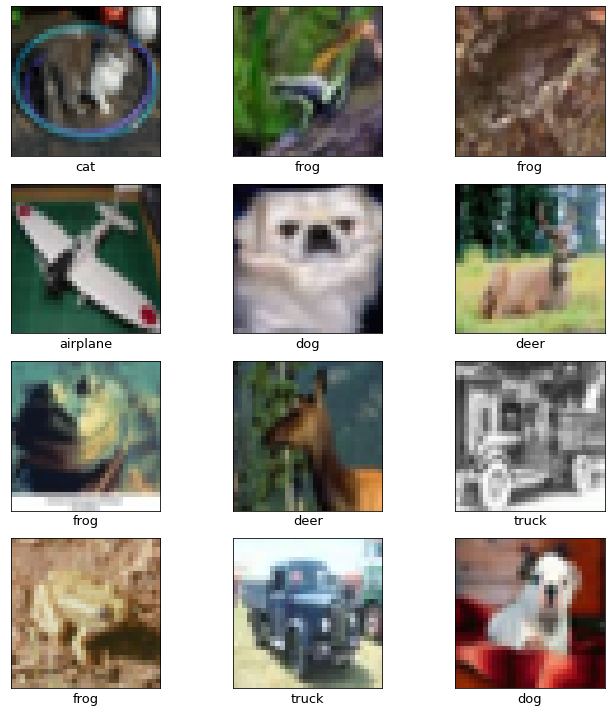

In [ ]:
#### plot images and corresponding labels

fig = plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(check_list[i][0], cmap='gray')
    plt.xlabel(class_types [np.argmax(check_list[i][1])], fontsize=13)
plt.tight_layout()    
plt.show()

### Vanilla Pipeline vs Pipeline Using ```tf.data``` & Prefetching 

An excellent description is given in the TensorFlow data pipeline [documentation](https://www.tensorflow.org/guide/data_performance). 

In [ ]:
### comparison of naive approach of training batch generation with ImageDataGenerator and tf. data 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

autotune = tf.data.AUTOTUNE ### most important function

In [ ]:
### creating data batch using ImageDatagenerator 
st1 = time.time()
train_datagen = ImageDataGenerator().flow(x=train_im, y=train_lab, batch_size=128, shuffle=True,)
et1 = time.time()
print ('time taken: ', et1-st1)

time taken:  0.2080059051513672


In [ ]:
st2 = time.time()
train_datagen_tfdata = training_data.shuffle(buffer_size=40000).batch(128).prefetch(buffer_size=autotune)
et2 = time.time()
print ('time taken: ', et2-st2)

time taken:  0.006140947341918945


In [ ]:
print ('tf dataset shuffle is about %3.2f faster than ImageDataGenerator'%((et1-st1)/(et2-st2)))

tf dataset shuffle is about 33.87 faster than ImageDataGenerator


### How to Include Augmentation with ```tf.data```  

Here we will use pre-processing layers, to build series of augmentations. 

We can also include a rescaling or resizing layer. (Important for normalizing images in this particular case).  

TensorFlow already has a nice documentation, with examples included; [Link](https://www.tensorflow.org/tutorials/images/data_augmentation#augment_a_dataset_and_train_a_model_with_it).  

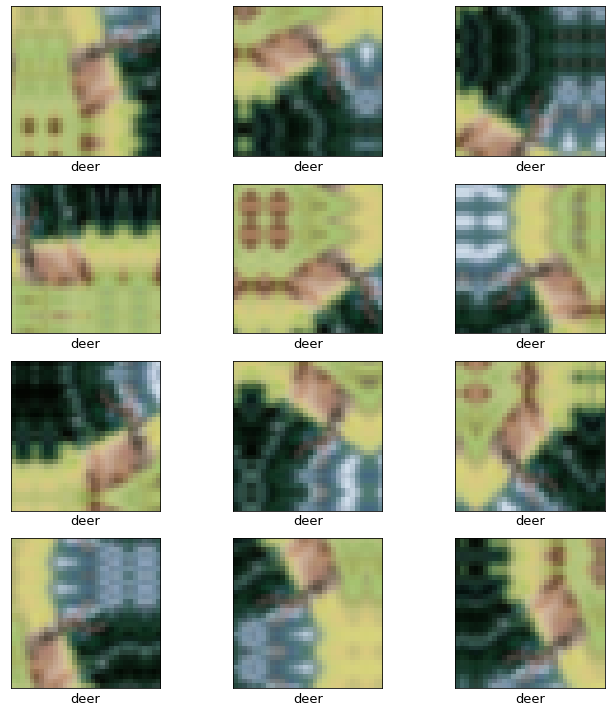

In [ ]:
from tensorflow.keras import layers

rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])

### create an iterable and apply the augmentation  

### let's try something fancy 
from itertools import islice, count

train_iter_5im, train_iter_5label = next(islice(training_data, 5, None)) # access the 5th element from the iterator



train_iter_5im = tf.expand_dims(train_iter_5im, 0)
train_iter_5label = train_iter_5label.numpy()

plt.figure(figsize=(10, 10))

for i in range(12):
  plt.subplot(4, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  aug_img = data_augmentation(train_iter_5im)
  plt.imshow(aug_img[0], cmap='gray')
  plt.xlabel(class_types [np.argmax(train_iter_5label)], fontsize=13)
plt.tight_layout()    
plt.show()

In [ ]:
train_data_batches = training_data.shuffle(buffer_size=40000).batch(128).prefetch(buffer_size=autotune)
valid_data_batches = validation_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=autotune)

### Use Pre-Trained ResNet 

We will use a pre-trained ResNet50 with [ImageNet](https://image-net.org/) data. For an example of transfer learning check the TensorFlow [documentation](https://www.tensorflow.org/guide/keras/transfer_learning).  

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model

In [ ]:
def create_model():
  base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
  # for layer in base_model.layers[:-30]:
  #   layer.trainable = False
  inputs = Input(shape=(32, 32, 3))
  rescale = rescale_layer(inputs)
  augmented = data_augmentation(rescale)
  resnet = base_model(augmented)
  pooling = layers.GlobalAveragePooling2D()(resnet)
  dropout = layers.Dropout(0.4)(pooling)
  outputs = Dense(len(class_types), activation="softmax")(dropout)
  model = Model(inputs=inputs, outputs=outputs)

  return model

model = create_model()
model.summary()  

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490 

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), 
                       metrics=['acc'])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=3, min_lr=1e-5, verbose=1)


history = model.fit(train_data_batches,
                  epochs = 60, 
                  validation_data=valid_data_batches,
                  callbacks=[reduce_lr])

Epoch 1/60
313/313 [==============================] - 39s 95ms/step - loss: 2.2618 - acc: 0.2761 - val_loss: 6.2458 - val_acc: 0.1000
Epoch 2/60
313/313 [==============================] - 27s 85ms/step - loss: 1.9582 - acc: 0.3647 - val_loss: 269.4729 - val_acc: 0.1000
Epoch 3/60
313/313 [==============================] - 27s 86ms/step - loss: 2.0624 - acc: 0.3417 - val_loss: 2.4389 - val_acc: 0.1761
Epoch 4/60
313/313 [==============================] - 27s 87ms/step - loss: 1.9604 - acc: 0.3533 - val_loss: 2.1525 - val_acc: 0.3519
Epoch 5/60
313/313 [==============================] - 27s 86ms/step - loss: 1.9256 - acc: 0.3693 - val_loss: 2.2613 - val_acc: 0.3255
Epoch 6/60
313/313 [==============================] - 26s 84ms/step - loss: 1.8426 - acc: 0.3928 - val_loss: 34.1340 - val_acc: 0.2439
Epoch 7/60
313/313 [==============================] - 27s 86ms/step - loss: 1.8325 - acc: 0.4001 - val_loss: 2.6583 - val_acc: 0.3758

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0

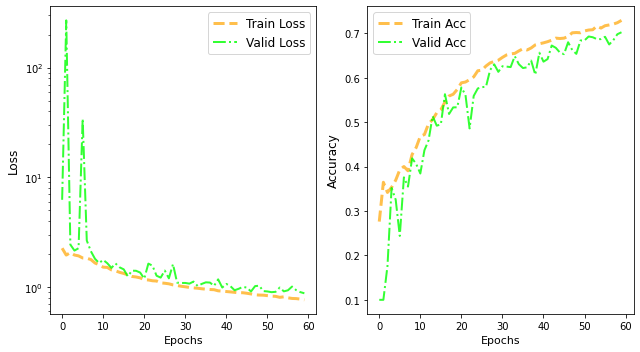

In [ ]:
### Plot train and validation curves
loss = history.history['loss']
v_loss = history.history['val_loss']

acc = history.history['acc']
v_acc = history.history['val_acc']

epochs = range(len(loss))

fig = plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
test_data_batches = test_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=autotune)


results = model.evaluate(test_data_batches)
print ("test loss, test acc:", results)

313/313 [==============================] - 4s 14ms/step - loss: 0.8881 - acc: 0.6984
test loss, test acc: [0.88810133934021, 0.6984000205993652]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def conf_matrix(predictions): 
    ''' Plots conf. matrix and classification report '''
    cm=confusion_matrix(y_test, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr=classification_report(y_test,
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()
    # fig.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/heatmap.png', dpi=250)

Classification Report:

              precision    recall  f1-score   support

    airplane       0.32      0.85      0.46      1000
  automobile       0.72      0.87      0.79      1000
        bird       0.79      0.51      0.62      1000
         cat       0.60      0.43      0.50      1000
        deer       0.88      0.40      0.55      1000
         dog       0.79      0.43      0.56      1000
        frog       0.67      0.81      0.73      1000
       horse       0.81      0.66      0.73      1000
        ship       0.89      0.71      0.79      1000
       truck       0.81      0.78      0.79      1000

    accuracy                           0.64     10000
   macro avg       0.73      0.64      0.65     10000
weighted avg       0.73      0.64      0.65     10000



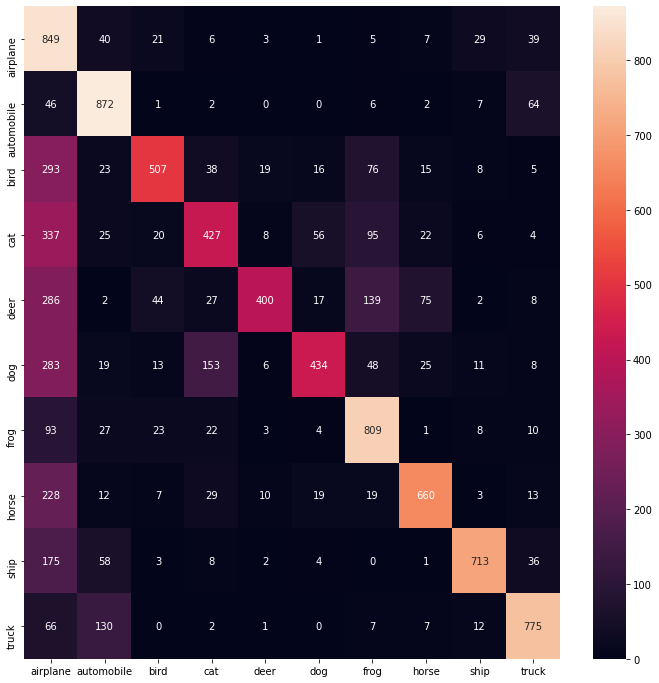

In [ ]:
pred_class_resnet50 = model.predict(x_test)

conf_matrix(pred_class_resnet50)